# Part 3 - Categorically Speaking

**Notice: This notebook is a modification of [cats.ipynb and targetencode.ipynb](https://mlbook.explained.ai/notebooks/index.html) by Terence Parr and Jeremy Howard, which were used by permission of the author.**

Please use this notebook to follow along with the lectures this week. Feel free to modify the code in any way. 

There may be minor differences between the notebook seen in the lecture videos and this one. 

### Reestablish Baseline

In [5]:
pip install category_encoders

     ---------------------------------------- 81.9/81.9 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from rfpimp import *
import category_encoders as ce

In [9]:
def evaluate(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [10]:
def showimp(rf, X, y):
    features = list(X.columns)
    features.remove('latitude')
    features.remove('longitude')
    features += [['latitude','longitude']]

    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

In [11]:
rent = pd.read_csv('rent.csv')

rent_clean = rent[(rent['price'] > 1000) & (rent['price'] < 10000)]
rent_clean = rent_clean[(rent_clean['longitude'] !=0) | (rent_clean['latitude']!=0)]
rent_clean = rent_clean[(rent_clean['latitude']>40.55) &
                        (rent_clean['latitude']<40.94) &
                        (rent_clean['longitude']>-74.1) &
                        (rent_clean['longitude']<-73.67)]

In [5]:
rent_clean.head().T

,0,1,2,3,4
bathrooms,1.0,1.0,1.0,1.5,1.0
bedrooms,1,2,2,3,0
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49,53a5b119ba8f7b61d4e010512e0dfc85,bfb9405149bfff42a92980b594c28234
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59,2016-06-24 07:54:24,2016-06-28 03:50:23
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Over-sized Studio w abundant closets. Availabl...
display_address,145 Borinquen Place,East 44th,East 56th Street,Metropolitan Avenue,East 34th Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',...",[],"['Doorman', 'Elevator', 'Fitness Center', 'Lau..."
latitude,40.7108,40.7513,40.7575,40.7145,40.7439
listing_id,7170325,7092344,7158677,7211212,7225292
longitude,-73.9539,-73.9722,-73.9625,-73.9425,-73.9743


In [6]:
rent_clean.shape

(48300, 15)

In [7]:
numfeatures = ['bathrooms', 'bedrooms', 'longitude', 'latitude']

X = rent_clean[numfeatures]
y = rent_clean['price']

In [8]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86771 using 2,431,170 tree nodes with 35.0 median tree depth


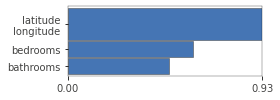

In [9]:
showimp(rf, X, y)

### Feature Engineering

What we will embark on now can be broadly categorized as *feature engineering*, which can be defined as: 

> the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data. (Jason Brownlee)

The goal is to discover (through domain knowledge, experimentation, etc.) which input features make it easier for the model to best predict the corresponding outputs. We won't cover all aspects of this topic, but will cover a few approaches that should prove useful in your practical work. 

#### Extracting Features from Strings

Our apartment rental data has a few features that are made up of *string* (or text): 
- `description` contains free-form text that presumably highlights all the desirable qualities of the apartment;
- `features` contains lists of specific amenities each apartment offers; and, 
- `photos` contains strings representing the filenames of pictures of the apartment. 

It would seem reasonable to think that some of the information contained in these columns would be connected to the price, since, after all, they are listed to show how much you are getting for the amount you have to spend. 

Let's consider each in turn, noting that processing free-form text may require a little more work and creativity than other columns. 

In [10]:
rent_text = rent_clean[['description', 'features', 'photos']].copy()
rent_text.head()

,description,features,photos
0,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,"['Dining Room', 'Pre-War', 'Laundry in Buildin...",['https://photos.renthop.com/2/7170325_3bb5ac8...
1,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,"['Doorman', 'Elevator', 'Laundry in Building',...",['https://photos.renthop.com/2/7092344_7663c19...
2,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,"['Doorman', 'Elevator', 'Laundry in Building',...",['https://photos.renthop.com/2/7158677_c897a13...
3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,[],['https://photos.renthop.com/2/7211212_1ed4542...
4,Over-sized Studio w abundant closets. Availabl...,"['Doorman', 'Elevator', 'Fitness Center', 'Lau...",['https://photos.renthop.com/2/7225292_901f198...


The first thing we should do is check to see if there are any missing values.

In [11]:
rent_text.isnull().sum()

description    1421
features          0
photos            0
dtype: int64

So, we will need to deal with this for the `description` column only. 

#### `Description`

If we look at the first couple descriptions, we see words like *spacious* and *renovated*. These may have predictive power because: 
- even though we have the number of bedrooms and bathrooms, it doesn't tell us how big the apartment is overall, since one 1 bed/1 bath apartment could have twice the square footage of another, which may be worth more money; and, 
- a renovated apartment could mean that everything has been update so it may look nicer and may have fewer problems compared to an apartment that has not been renovated. 

It's worth seeing if these can provide us with any performance improvement. 

First, let's replace the missing values with an empty string '' and convert the description to lower case text. 

In [12]:
#The fillna() method replaces the NULL values with a specified value.
rent_clean['description'] = rent_clean['description'].fillna('')  
rent_clean['description'] = rent_clean['description'].str.lower() 
rent_clean.head(3).T

,0,1,2
bathrooms,1.0,1.0,1.0
bedrooms,1,2,2
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59
description,spacious 1 bedroom 1 bathroom in williamsburg!...,brand new gut renovated true 2 bedroomfind you...,**flex 2 bedroom with full pressurized wall**l...
display_address,145 Borinquen Place,East 44th,East 56th Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',..."
latitude,40.7108,40.7513,40.7575
listing_id,7170325,7092344,7158677
longitude,-73.9539,-73.9722,-73.9625


Note that converting the text to lower case will remove the problem of Python treating *Spacious* and *spacious* as different, which is the default behaviour. 

Now let's create two new columns based on these two concepts of *spacious* and *renovated*. 

In [13]:
rent_text.isnull().sum()

description    1421
features          0
photos            0
dtype: int64

In [14]:
rent_clean['renov'] = rent_clean['description'].str.contains("renov")
rent_clean['large_apt'] = rent_clean['description'].str.contains("spacious")
rent_clean.head(3).T

,0,1,2
bathrooms,1.0,1.0,1.0
bedrooms,1,2,2
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59
description,spacious 1 bedroom 1 bathroom in williamsburg!...,brand new gut renovated true 2 bedroomfind you...,**flex 2 bedroom with full pressurized wall**l...
display_address,145 Borinquen Place,East 44th,East 56th Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',..."
latitude,40.7108,40.7513,40.7575
listing_id,7170325,7092344,7158677
longitude,-73.9539,-73.9722,-73.9625


It's probably a good idea to check how many apartments have these new features we have created, because if almost all (or none) of them have this feature it may not be much help in making predictions. 

In [15]:
rent_clean['renov'].sum()

17327

In [16]:
rent_clean['large_apt'].sum()

10496

In [17]:
rent_clean.shape

(48300, 17)

That seems like a decent amount so let's use them to build a model. Remember that `False` and `True` get treated as 0 and 1, respectively, so even though they look like words, the computer is going to treat them as numbers. 

In [18]:
numfeatures

['bathrooms', 'bedrooms', 'longitude', 'latitude']

In [19]:
X = rent_clean[numfeatures + ['renov', 'large_apt']]
y = rent_clean['price']

In [20]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86651 using 3,208,726 tree nodes with 36.0 median tree depth


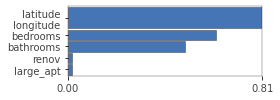

In [21]:
showimp(rf, X, y)

While these new features don't seem to have much predictive power, it is usually a good idea to try out different ideas like this based on our understanding of what may or may not be important to someone looking for an apartment. 

##### Exercise

In a manner similar to what we did to create the new features `renov` and `large_apt`, try creating other features for: 
- apartments that have a balcony (see if you can do it in a way so you capture descriptions that say both *balcony* and *balconies*; and 
- apartments that allow pets, which in this case, is either *cats* or *dogs*. (Hint: you will need to combine the two conditions with a [logical operator](https://www.w3schools.com/python/gloss_python_logical_operators.asp).)

In [22]:
rent_clean['balcony'] = rent_clean['description'].str.contains("balcon")
rent_clean['pet'] = rent_clean['description'].str.contains("cats|dogs")
rent_clean.head(10).T

,0,1,2,3,4,5,6,7,8,9
bathrooms,1.0,1.0,1.0,1.5,1.0,1.0,2.0,1.0,0.0,3.0
bedrooms,1,2,2,3,0,3,3,0,1,3
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49,53a5b119ba8f7b61d4e010512e0dfc85,bfb9405149bfff42a92980b594c28234,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,0d01cabe55fa5192cdbcabd5c585c1ea,d48767c37a934daaf0bbb0e58c755d0c,d1ca33a2853e64fad6e4009d5d5d168f,5f35dc2f0191baf109221752e6ee0c48
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59,2016-06-24 07:54:24,2016-06-28 03:50:23,2016-06-28 05:59:06,2016-06-08 06:21:36,2016-06-05 05:28:22,2016-06-09 04:42:03,2016-06-28 03:26:18
description,spacious 1 bedroom 1 bathroom in williamsburg!...,brand new gut renovated true 2 bedroomfind you...,**flex 2 bedroom with full pressurized wall**l...,a brand new 3 bedroom 1.5 bath apartmentenjoy ...,over-sized studio w abundant closets. availabl...,this spectacular converted 3 bed apartment all...,amazing deal!! brand new renovations in this h...,no fee large renovated sun splashed studio. wa...,extra large one bedroom apartment located in p...,listed: 06/26/16<br /><br />available:...
display_address,145 Borinquen Place,East 44th,East 56th Street,Metropolitan Avenue,East 34th Street,East 16th Street,East 13th Street,York Avenue,E 19 Street,Hicks Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',...",[],"['Doorman', 'Elevator', 'Fitness Center', 'Lau...","['Doorman', 'Elevator', 'Loft', 'Dishwasher', ...","['Fireplace', 'Laundry in Unit', 'Dishwasher',...","['Elevator', 'Laundry in Building', 'Dishwashe...",['Hardwood Floors'],"['Cats Allowed', 'Dogs Allowed']"
latitude,40.7108,40.7513,40.7575,40.7145,40.7439,40.7348,40.7302,40.7769,40.7346,40.699
listing_id,7170325,7092344,7158677,7211212,7225292,7226687,7126989,7114138,7131094,7224815
longitude,-73.9539,-73.9722,-73.9625,-73.9425,-73.9743,-73.9865,-73.9826,-73.9467,-73.9811,-73.9943


In [23]:
print(rent_clean['pet'].sum())
print(rent_clean['balcony'].sum())

700
2501


In [24]:
X = rent_clean[numfeatures + ['pet', 'balcony']]
y = rent_clean['price']

In [25]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86734 using 2,546,114 tree nodes with 36.0 median tree depth


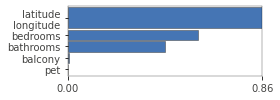

In [26]:
showimp(rf, X, y)

#### `Features`

The column `features`, which is not to be confused with the general machine learning term, refers to specific amenities that an apartment offers. Let's take a look at some entries to see what kind of information is available and whether or not it may help our model improve its performance. 

In [27]:
rent_clean['features'][:10]

0    ['Dining Room', 'Pre-War', 'Laundry in Buildin...
1    ['Doorman', 'Elevator', 'Laundry in Building',...
2    ['Doorman', 'Elevator', 'Laundry in Building',...
3                                                   []
4    ['Doorman', 'Elevator', 'Fitness Center', 'Lau...
5    ['Doorman', 'Elevator', 'Loft', 'Dishwasher', ...
6    ['Fireplace', 'Laundry in Unit', 'Dishwasher',...
7    ['Elevator', 'Laundry in Building', 'Dishwashe...
8                                  ['Hardwood Floors']
9                     ['Cats Allowed', 'Dogs Allowed']
Name: features, dtype: object

We can see that some of the features listed could reasonably be related to the price of an apartment. For example, one would expect that having a *doorman* would be associated with higher-priced apartments. 

In [28]:
rent_clean['features'] = rent_clean['features'].fillna('')
rent_clean['features'] = rent_clean['features'].str.lower() 

for feature in ['doorman', 'parking', 'garage', 'laundry']:
    rent_clean[feature] = rent_clean['features'].str.contains(feature)
    
rent_clean[['doorman', 'parking', 'garage', 'laundry']].head(5)

,doorman,parking,garage,laundry
0,False,False,False,True
1,True,False,False,True
2,True,False,False,True
3,False,False,False,False
4,True,False,False,True


And now check how many apartments have these new features we have created, because if almost all (or none) of them have this feature it may not be much help in making predictions. 

In [29]:
rent_clean[['doorman', 'parking', 'garage', 'laundry']].sum()

doorman    20248
parking      654
garage      1006
laundry    23172
dtype: int64

Seems like enough apartments have these particular features, so we can build and evaluate our model. 

In [30]:
X = rent_clean[numfeatures + ['doorman', 'parking', 'garage', 'laundry']]
y = rent_clean['price']
X.head(3).T

,0,1,2
bathrooms,1.0,1.0,1.0
bedrooms,1,2,2
longitude,-73.9539,-73.9722,-73.9625
latitude,40.7108,40.7513,40.7575
doorman,False,True,True
parking,False,False,False
garage,False,False,False
laundry,True,True,True


In [31]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86986 using 2,931,708 tree nodes with 36.0 median tree depth


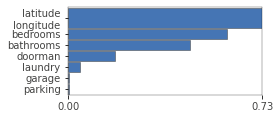

In [32]:
showimp(rf, X, y)

##### Exercise

In a manner similar to what we did using `features`, try creating a few more columns based on other apartment characteristics that you can find. (Hint: Try using `rent_clean['features'][0:10]` and replace the start and end rows to explore what's listed in the `features` column. See if you can find anything that might be related to price. ) 

In [33]:
rent_clean['features'][0:10]

0    ['dining room', 'pre-war', 'laundry in buildin...
1    ['doorman', 'elevator', 'laundry in building',...
2    ['doorman', 'elevator', 'laundry in building',...
3                                                   []
4    ['doorman', 'elevator', 'fitness center', 'lau...
5    ['doorman', 'elevator', 'loft', 'dishwasher', ...
6    ['fireplace', 'laundry in unit', 'dishwasher',...
7    ['elevator', 'laundry in building', 'dishwashe...
8                                  ['hardwood floors']
9                     ['cats allowed', 'dogs allowed']
Name: features, dtype: object

In [34]:
for feature in ['dining', 'dishwasher', 'hardwood', 'elevator']:
    rent_clean[feature] = rent_clean['features'].str.contains(feature)
    
rent_clean[['dining', 'dishwasher', 'hardwood', 'elevator']].head(5)

,dining,dishwasher,hardwood,elevator
0,True,True,True,False
1,False,True,True,True
2,False,True,True,True
3,False,False,False,False
4,False,False,False,True


In [35]:
rent_clean[['dining', 'dishwasher', 'hardwood', 'elevator']].sum()

dining         4684
dishwasher    20170
hardwood      24021
elevator      25492
dtype: int64

In [36]:
X = rent_clean[numfeatures + ['dining', 'dishwasher', 'hardwood', 'elevator']]
y = rent_clean['price']
rf, oob = evaluate(X, y)

OOB R^2 is 0.86390 using 3,453,450 tree nodes with 37.0 median tree depth


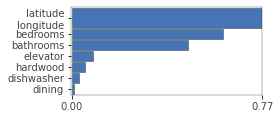

In [37]:
showimp(rf, X, y)

##### More Counting

Counting is something that humans do well, so let's see if we can make it work for us here. Maybe higher-priced apartments have more for the manager to talk about so descriptions of the rental unit, lists of amenities, and the number of pictures of the apartment would all be higher than for lower-priced apartments. We can see if this has any impact on our model by doing some straightforward counting on the strings in these columns.  The basic approach is that for each apartment (row) we: 
- split the words in the `description` after each space (" ") to create a list and then count how many elements are in the list; 
- split the list of amenities in `features` after each comma (",") to create a list and then count how many elements are in the list; and, 
- split the list of filenames in `photos` after each comma (",") to create a list and then count how many elements are in the list.

Using the `description` as an example, here is what the original data looks like:

In [38]:
rent_clean["description"]

0        spacious 1 bedroom 1 bathroom in williamsburg!...
1        brand new gut renovated true 2 bedroomfind you...
2        **flex 2 bedroom with full pressurized wall**l...
3        a brand new 3 bedroom 1.5 bath apartmentenjoy ...
4        over-sized studio w abundant closets. availabl...
                               ...                        
49347    there is 700 square feet of recently renovated...
49348    2 bedroom apartment with updated kitchen, rece...
49349    no brokers fee * never lived 1 bedroom 1 bathr...
49350    wonderful bright chelsea 2 bedroom apartment o...
49351    ***prime midtown east off park ave***true 3 be...
Name: description, Length: 48300, dtype: object

And here is what it looks like after we split each description on the white spaces between the words:

In [39]:
rent_clean["description"].apply(lambda x: x.split())

0        [spacious, 1, bedroom, 1, bathroom, in, willia...
1        [brand, new, gut, renovated, true, 2, bedroomf...
2        [**flex, 2, bedroom, with, full, pressurized, ...
3        [a, brand, new, 3, bedroom, 1.5, bath, apartme...
4        [over-sized, studio, w, abundant, closets., av...
                               ...                        
49347    [there, is, 700, square, feet, of, recently, r...
49348    [2, bedroom, apartment, with, updated, kitchen...
49349    [no, brokers, fee, *, never, lived, 1, bedroom...
49350    [wonderful, bright, chelsea, 2, bedroom, apart...
49351    [***prime, midtown, east, off, park, ave***tru...
Name: description, Length: 48300, dtype: object

And here is what it looks like after we split and count:

In [40]:
rent_clean["description"].apply(lambda x: len(x.split()))

0         75
1        129
2        117
3         93
4         39
        ... 
49347    129
49348     69
49349     79
49350    114
49351     56
Name: description, Length: 48300, dtype: int64

Let's do this procedure on all 3 columns and add the new columns to our data for training. 

In [41]:
rent_clean['num_desc_words'] = rent_clean["description"].apply(lambda x: len(x.split()))
rent_clean['num_features'] = rent_clean["features"].apply(lambda x: len(x.split(",")))
rent_clean['num_photos'] = rent_clean["photos"].apply(lambda x: len(x.split(",")))
rent_clean[['num_desc_words', 'num_features', 'num_photos']].head()

,num_desc_words,num_features,num_photos
0,75,7,12
1,129,6,6
2,117,6,6
3,93,1,5
4,39,4,4


Now let's use these columns to build a model: 

In [42]:
X = rent_clean[numfeatures + ['num_desc_words', 'num_features', 'num_photos']]
y = rent_clean['price']

In [43]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.85373 using 4,829,456 tree nodes with 41.0 median tree depth


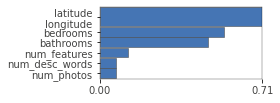

In [44]:
showimp(rf, X, y)

### What We Have So Far

Let's put all the features we've worked on so far together and build a model so we can see how it all fits together. 

In [45]:
X = rent_clean[numfeatures + 
               ['renov', 'large_apt'] + 
               ['doorman', 'parking', 'garage', 'laundry'] +
               ['num_desc_words', 'num_features', 'num_photos']]
y = rent_clean['price']

In [46]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86097 using 4,776,698 tree nodes with 43.0 median tree depth


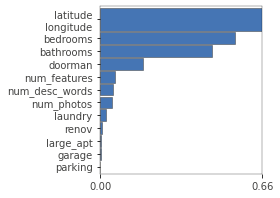

In [47]:
showimp(rf, X, y)